In [1]:
#import standard libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
%matplotlib inline

In [2]:
#read data
order_products_p = pd.read_csv("../instacart_project/order_products__prior.csv",
                               dtype={"order_id":np.int32,
                                      "product_id":np.int32,
                                      "add_to_cart_order":np.int16,
                                      "reordered":np.int8})
orders = pd.read_csv("../instacart_project/orders.csv",
                    dtype={"order_id":np.int32,
                           "user_id":np.int32,
                           "order_number":np.int8,
                           "order_dow":np.int8,
                           "order_hour_of_day":np.int8,
                           "days_since_prior_order":np.float32})
products = pd.read_csv("../instacart_project/products.csv",
                       dtype={"product_id":np.int32,
                              "aisle_id":np.int16,
                              "department_id":np.int8},usecols=["product_id","aisle_id","department_id"])

variable_type_dict = {"order_id":"categorical",
                      "product_id":"categorical",
                      "add_to_cart_order":"continuous",
                      "reordered":"categorical",
                      "user_id":"categorical",
                      "eval_set":"categorical",
                      "order_number":"continuous",
                      "order_dow":"categorical",
                      "order_hour_of_day":"categorical",
                      "days_since_prior_order":"continuous"}

In [3]:
#merge order info into products
order_products_p = order_products_p.merge(orders,on="order_id",how="inner")

count    3.243449e+07
mean     5.896975e-01
std      4.918886e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: reordered, dtype: float64


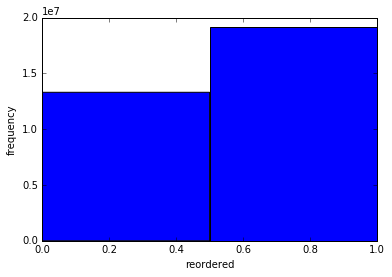

count    3.243449e+07
mean     8.351076e+00
std      7.126671e+00
min      1.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.100000e+01
max      1.450000e+02
Name: add_to_cart_order, dtype: float64


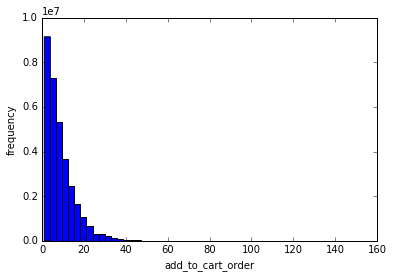

count    3.421083e+06
mean     1.715486e+01
std      1.773316e+01
min      1.000000e+00
25%      5.000000e+00
50%      1.100000e+01
75%      2.300000e+01
max      1.000000e+02
Name: order_number, dtype: float64


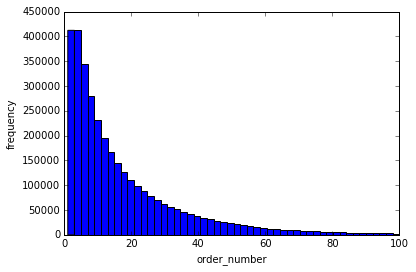

count    3.214874e+06
mean     1.113265e+01
std      9.161989e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.500000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64


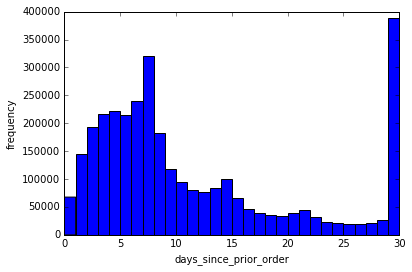

In [4]:
#Explaratory data analysis

#Target variable analysis
print(order_products_p.reordered.describe())
reordered = order_products_p.reordered.values
plt.hist(reordered,bins=2)
plt.xlabel("reordered")
plt.ylabel("frequency")
plt.show()

#Continuous variable analysis
#add to cart order number
print(order_products_p.add_to_cart_order.describe())
add_to_cart_order = order_products_p.add_to_cart_order.values
plt.hist(add_to_cart_order,bins=50)
plt.xlabel("add_to_cart_order")
plt.ylabel("frequency")
plt.show()

#order number
print(orders.order_number.describe())
order_number = orders.order_number.values
plt.hist(order_number,bins=50)
plt.xlabel("order_number")
plt.ylabel("frequency")
plt.show()

#days since prior order
print(orders.days_since_prior_order.describe())
days_since_prior_order = orders[orders["days_since_prior_order"].notnull()]["days_since_prior_order"]
days_since_prior_order = days_since_prior_order.values
plt.hist(days_since_prior_order,bins=30)
plt.xlabel("days_since_prior_order")
plt.ylabel("frequency")
plt.show()

Target variable (reordered) is not greatly imbalanced.

The distribution of the add_to_cart_order variable has a positive skew, this is probably because the amount of products per order is rarely very high. This is confirmed by the 75th percentile being very low (11) compared to the maximum value (145) of variable.

The situation is fairly similar with the order_number variable, again there is a positive skew. This is probably because the amount of orders per user is rarely very high. This is confirmed by the 75th percentile being fairly low (23) compared to the maximum value (100) of variable.

The distribution of the days_since_prior_order is multimodal, with 7 and 30 being the two modes. This is likely because people tend to do their orders weekly and monthly. Perhaps Instacart offers an automatic reorder feature

count    3.421083e+06
mean     2.776219e+00
std      2.046829e+00
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      6.000000e+00
Name: order_dow, dtype: float64


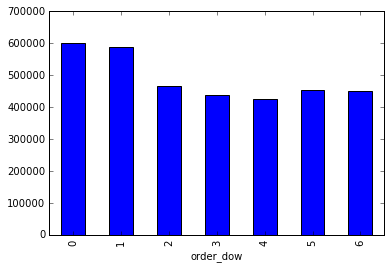

count    3.421083e+06
mean     1.345202e+01
std      4.226088e+00
min      0.000000e+00
25%      1.000000e+01
50%      1.300000e+01
75%      1.600000e+01
max      2.300000e+01
Name: order_hour_of_day, dtype: float64


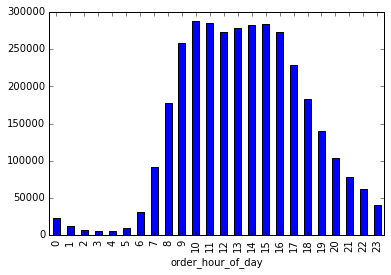

In [5]:
#Categorical variable analysis
dow_gb = orders.groupby("order_dow").count()["order_id"]
hour_of_day_gb = orders.groupby("order_hour_of_day").count()["order_id"]

print(orders.order_dow.describe())
dow_gb.plot(kind="bar",x=dow_gb.index,y=dow_gb.values)
plt.show()
print(orders.order_hour_of_day.describe())
hour_of_day_gb.plot(kind="bar",x=hour_of_day_gb.index,y=hour_of_day_gb.values)
plt.show()

According to the graphs above the orders are basically evenly distributed over the days of the week with slightly more orders on Monday and Tuesday.

Naturally during hours when most people are usually sleeping orders are significantly lower. During working hours orders are much higher. This is interesting perhaps it suggests Instacart is generally more popular with people who work which makes sense because they will have less time to go to a physical store and will value a service that can help them avoid doing this. 

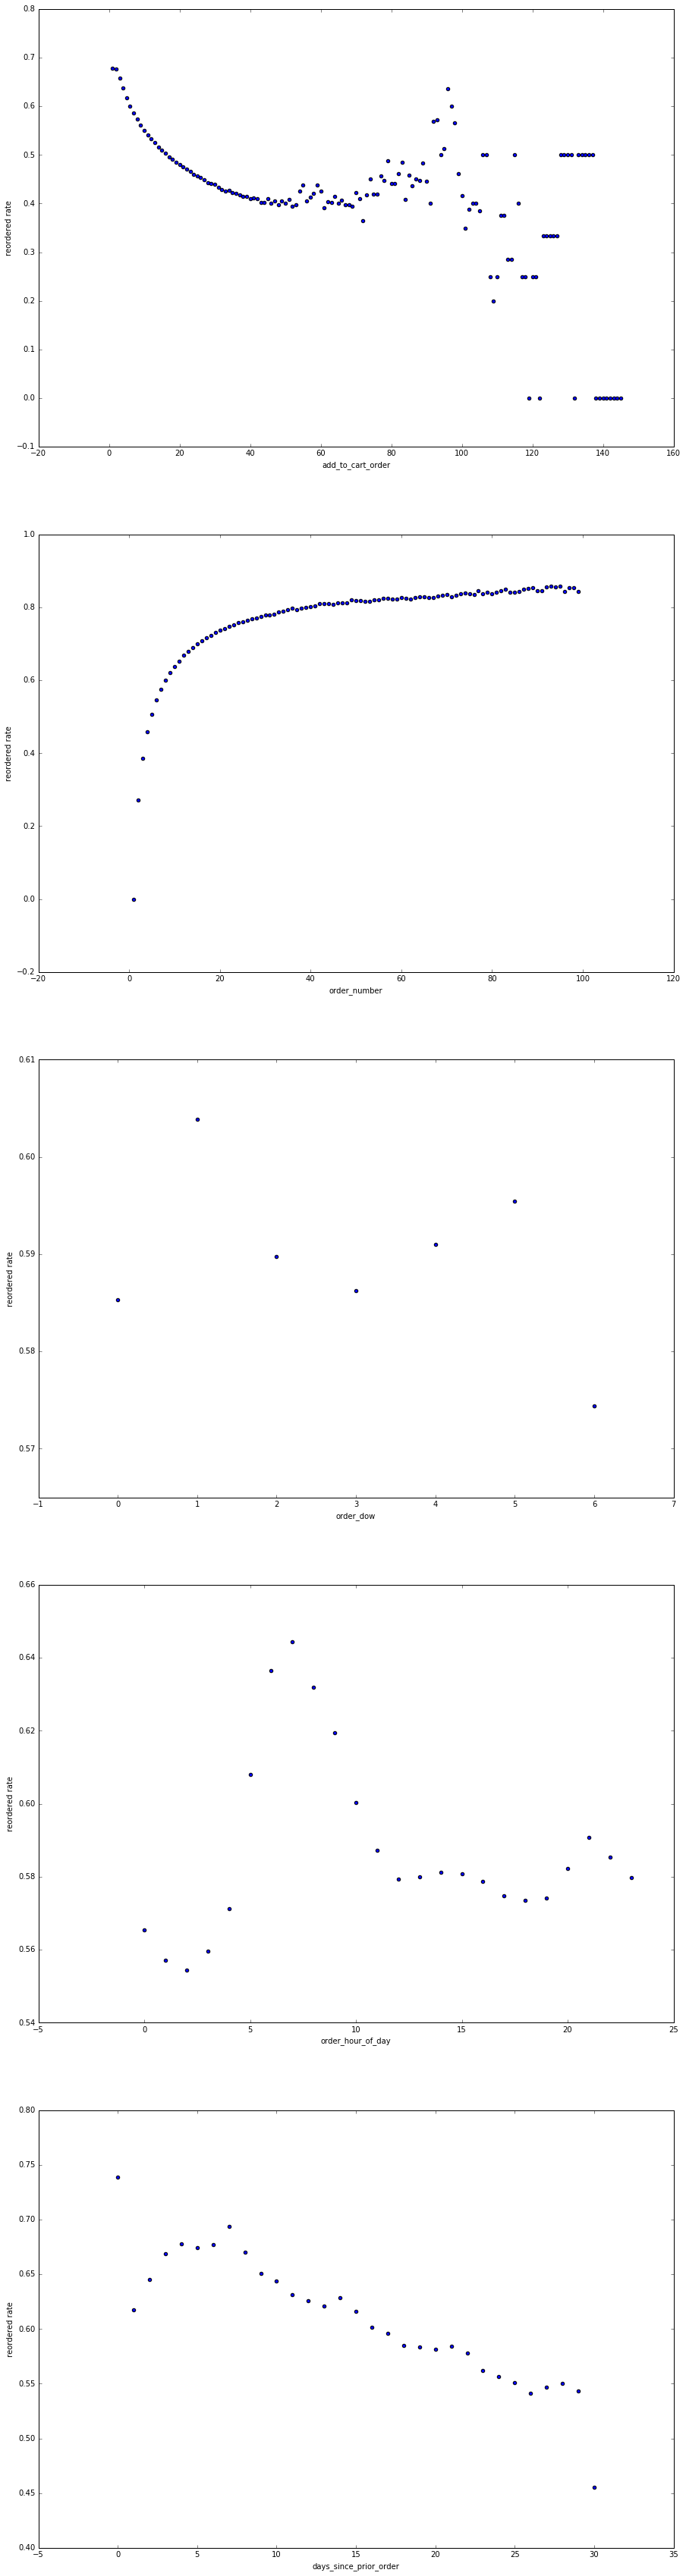

{'add_to_cart_order': -0.57785086213458103, 'order_dow': -0.40753456044343345, 'days_since_prior_order': -0.91614957906887007, 'order_number': 0.70425865552336597, 'order_hour_of_day': -0.037886918981047089}


In [7]:
#Reorder rate by independent variable analysis
scatter_list = ["add_to_cart_order","order_number","order_dow","order_hour_of_day","days_since_prior_order"]

fig = plt.figure(figsize=(15,60))
corr_rate_dict = {}

for i, v in enumerate(scatter_list):
    reordered_rate_df = pd.DataFrame()
    reordered_rate_df["ordered"] = order_products_p.groupby(v).count()["reordered"]
    reordered_rate_df["reordered"] = order_products_p.groupby(v).sum()["reordered"]
    reordered_rate_df["reordered rate"] = reordered_rate_df["reordered"]/reordered_rate_df["ordered"]
    reordered_rate_df.reset_index(inplace=True)
    corr_df = reordered_rate_df.corr()["reordered rate"]
    corr_rate_dict[v] = corr_df.loc[v]
    ax = fig.add_subplot(len(scatter_list),1,i+1)
    reordered_rate_df.plot(kind="scatter",x=v,y="reordered rate",ax=ax)

plt.show()
print(corr_rate_dict)

In [8]:
order_products_p.corr()["reordered"]

order_id                 -0.000253
product_id                0.003718
add_to_cart_order        -0.133024
reordered                 1.000000
user_id                  -0.000862
order_number              0.306840
order_dow                -0.006949
order_hour_of_day        -0.023300
days_since_prior_order   -0.132814
Name: reordered, dtype: float64

With most of the independent variables of interest the correlation with the target variable is very weak. From the graphs and correlation dictionary above we can see that the correlation of the independent variables of interest and the rate of reorder is:

 - strong for: days_since_prior_order and order_number
 - moderate for: add_to_cart_order
 - weak for: order_dow, order_hour_of_day

Consider looking at Chi-Square, ANOVA and Z-Test/T-Test

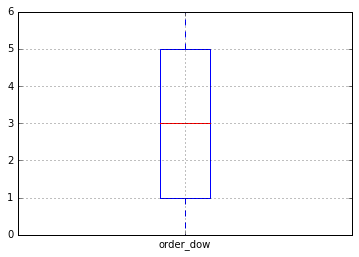

In [9]:
#Outlier analysis
orders.boxplot(column="order_dow")

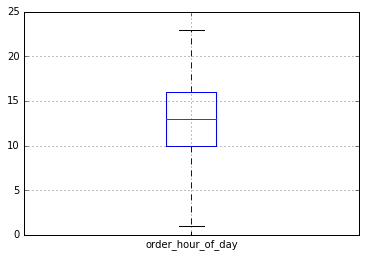

In [10]:
orders.boxplot(column="order_hour_of_day")

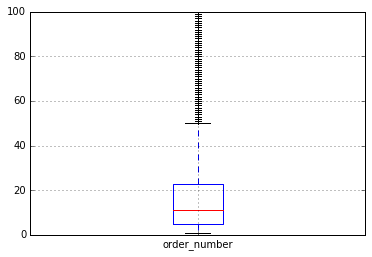

In [11]:
orders.boxplot(column="order_number")

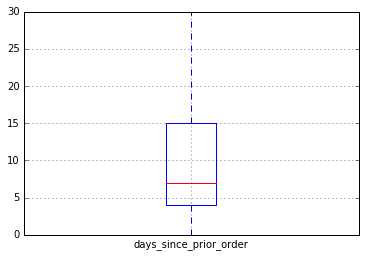

In [12]:
orders.boxplot(column="days_since_prior_order")

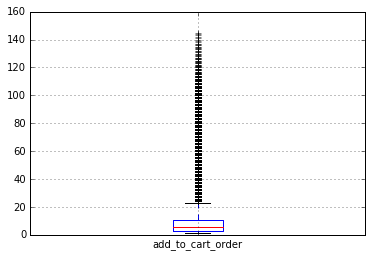

In [13]:
order_products_p.boxplot(column="add_to_cart_order")

According to the above box-plots the order_number and add_to_cart_order variables may contain some outliers. I think these are likely to be natural outliers either because some people have ordered many times more than on average and some people have many more products in their orders than the average amount. It might be interesting to look at building seperate models for these contacts. To see if it improves predictive capability.

In [14]:
#Make outlier tags in the data.
import scipy.stats as stats
percentile_25 = np.percentile(orders["order_number"],25)
percentile_75 = np.percentile(orders["order_number"],75)
IQR = stats.iqr(orders["order_number"])
low = percentile_25 - (1.5 * IQR)
high = percentile_75 + (1.5 * IQR)
orders["order_num_outlier"] = np.where(np.logical_or(orders["order_number"]>high,orders["order_number"]<low),1,0).astype(np.int8)

In [15]:
percentile_25 = np.percentile(order_products_p["add_to_cart_order"],25)
percentile_75 = np.percentile(order_products_p["add_to_cart_order"],75)
IQR = stats.iqr(order_products_p["add_to_cart_order"])
low = percentile_25 - (1.5 * IQR)
high = percentile_75 + (1.5 * IQR)
order_products_p["atco_outlier"] = np.where(np.logical_or(order_products_p["add_to_cart_order"]>high,
                                                          order_products_p["add_to_cart_order"]<low),1,0).astype(np.int8)

The amount of records that fall into the outlier threshold is quite significant so maybe it is actually not necessary to treat them seperately.

Next we need to look at engineering features that better describe the structure of the data, as this is likely to increase the predictive capability of the final model. Intuitively these features should probably focus on, among other characteristics, frequency and recency of buying behaviour.

First I think we should work to create a training and test dataset. Since we are trying to predict which products a customer will reorder in their next order, we should look at all products that the customer has previously ordered and try to predict which products they will order in their next order.

In [16]:
#Make train and test datasets
train_users = orders[orders["eval_set"]=="train"]["user_id"].unique()
test_users = orders[orders["eval_set"]=="test"]["user_id"].unique()

train = orders[orders["user_id"].isin(train_users)][["order_id","user_id"]]
train = order_products_p[["order_id","product_id"]].merge(train,on="order_id",how="inner")
train.drop(["order_id"],axis="columns",inplace=True)
cols = ["order_id","user_id","order_number","order_dow","order_hour_of_day","days_since_prior_order","order_num_outlier"]
train = train.merge(orders[orders["eval_set"]=="train"][cols],on="user_id",how="inner")
order_products_t = pd.read_csv("../instacart_project/order_products__train.csv",
                               dtype={"order_id":np.int32,
                                      "product_id":np.int32,
                                      "reordered":np.int8},usecols=["order_id","product_id","reordered"])
train = train.merge(order_products_t,on=["order_id","product_id"],how="left")
del order_products_t
train["reordered"].fillna(0,inplace=True)
train["reordered"] = train["reordered"].astype(np.int8)

test = orders[orders["user_id"].isin(test_users)][["order_id","user_id"]]
test = order_products_p[["order_id","product_id"]].merge(test,on="order_id",how="inner")
test.drop(["order_id"],axis="columns",inplace=True)
test = test.merge(orders[orders["eval_set"]=="test"][cols],on="user_id",how="inner")

train.drop_duplicates(subset=["order_id","product_id"],inplace=True)
test.drop_duplicates(subset=["order_id","product_id"],inplace=True)

In [17]:
#Import sci-kit learn libaries, identify raw predictor variables, instantiate model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

cols = ["order_number","order_dow","order_hour_of_day","days_since_prior_order"]

dtc = DecisionTreeClassifier(random_state=1)

In [18]:
#First model with raw features, to get a base line
scores = cross_val_score(estimator=dtc,X=train[cols],y=train["reordered"],scoring="f1",cv=10)
print(scores.mean())

KeyboardInterrupt: 

0.0009111 on test data

In [ ]:
#train another model treating outlier seperately
ratio = train["order_num_outlier"].value_counts()
ratio = ratio.loc[1]/(ratio.loc[0]+ratio.loc[1])
ratio
train_normal = train[train["order_num_outlier"]==0]
train_outlier = train[train["order_num_outlier"]==1]
scores_normal = cross_val_score(estimator=dtc,X=train_normal[cols],y=train_normal["reordered"],scoring="f1",cv=10)
scores_outlier = cross_val_score(estimator=dtc,X=train_outlier[cols],y=train_outlier["reordered"],scoring="f1",cv=10)
scores_normal *= (1-ratio)
scores_outlier *= ratio
scores = scores_normal + scores_outlier
print(scores.mean())

Treating the high order outliers in a seperate model seems to improve predictive accuracy quite alot, but I will need to confirm if I've coded the above correctly

0.0009300 on the test data, so a slight improvement but still very low likely the primary way to gain accuracy is to engineer features from the prior orders

In [ ]:
#train another model with outlier flag
cols.append("order_num_outlier")
scores = cross_val_score(estimator=dtc,X=train[cols],y=train["reordered"],scoring="f1",cv=10)
print(scores.mean())